#### Total time taken by the notebook on provided image is around 150 seconds (vary on system configuration)

In [1]:
import time
tik = time.time()

In [2]:
import os
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [3]:
def img2double(img):
    info = np.iinfo(img.dtype)
    return img.astype(np.float) / info.max


def svd(img, full_matrices=False):
    U, S, VT = np.linalg.svd(img, full_matrices=full_matrices)
    return (U, np.diag(S), VT)


def perc_storage(rank, n_rows, n_cols):
    original_space = n_rows*n_cols
    compressed_space = n_rows*rank + rank + n_cols*rank
    return compressed_space / original_space * 100


def perc_energy(S, r):
    return (np.trace(S[:r]) / np.trace(S)) * 100


def frobenious_norm(A, B):
    return np.linalg.norm(A-B, ord='fro')


def get_optimal_rank_by_energy(X, max_energy):
    _, S, _ = svd(X)
    max_rank_ = S.shape[0]
    opt_rank_ = 1
    
    while True:
        energy = perc_energy(S, opt_rank_)
        if energy < max_energy:
            opt_rank_ += 1
            continue
        if energy > max_energy:
            opt_rank_ -= 1
        
        break
        
    return opt_rank_
    

def get_optimal_rank_by_storage(X, max_storage):
    _, S, _ = svd(X)
    max_rank_ = S.shape[0]
    opt_rank_ = 1
    
    while True:
        storage = perc_storage(opt_rank_, *S.shape)
        if storage < max_storage:
            opt_rank_ += 1
            continue
        if storage > max_storage:
            opt_rank_ -= 1
        
        break

    return opt_rank_


def get_optimal_rank_by_norm(X, max_norm):
    U, S, VT = svd(X)
    max_rank_ = S.shape[0]
    opt_rank_ = 1
    
    while True:
        X_r = U[:, :opt_rank_] @ S[:opt_rank_, :opt_rank_] @ VT[:opt_rank_, :]

        norm = frobenious_norm(X, X_r)
        if norm > max_norm:
            opt_rank_ += 1
            continue
        
        break
        
    return opt_rank_


def get_optimal_rank(X, by='energy', **kwargs):
    VALID_BY = ['energy', 'storage', 'norm']
    
    if not isinstance(by, str):
        raise ValueError(f'by should be of type `str` but got {type(by)}')
        
    if by not in VALID_BY:
        raise ValueError(f'by should be one of {VALID_BY}')
        
    if by == 'energy':
        
        if len(X.shape) == 3:
            opt_rank_ = np.mean(
                [
                    get_optimal_rank_by_energy(X[:, :, 0], kwargs['max_energy']),
                    get_optimal_rank_by_energy(X[:, :, 1], kwargs['max_energy']),
                    get_optimal_rank_by_energy(X[:, :, 2], kwargs['max_energy']),
                ]
            )
        else:
            opt_rank_ = get_optimal_rank_by_energy(X, kwargs['max_energy'])
            
    elif by == 'storage':
        
        if len(X.shape) == 3:
            opt_rank_ = np.mean(
                [
                    get_optimal_rank_by_storage(X[:, :, 0], kwargs['max_storage']),
                    get_optimal_rank_by_storage(X[:, :, 1], kwargs['max_storage']),
                    get_optimal_rank_by_storage(X[:, :, 2], kwargs['max_storage']),
                ]
            )
        else:
            opt_rank_ = get_optimal_rank_by_storage(X, kwargs['max_storage'])

    else:
        
        if len(X.shape) == 3:
            opt_rank_ = np.mean(
                [
                    get_optimal_rank_by_norm(X[:, :, 0], kwargs['max_norm']),
                    get_optimal_rank_by_norm(X[:, :, 1], kwargs['max_norm']),
                    get_optimal_rank_by_norm(X[:, :, 2], kwargs['max_norm']),
                ]
            )
        else:
            opt_rank_ = get_optimal_rank_by_norm(X, kwargs['max_norm'])

    return int(opt_rank_)

original image: (2000, 1500, 3)
grayscaled image: (2000, 1500)


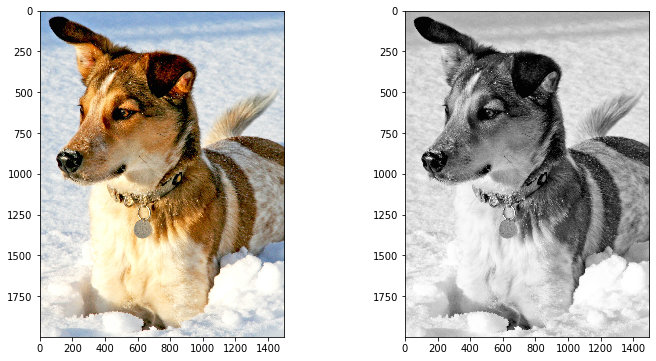

In [4]:
img_path = os.path.join('img', 'dog.jpg')
img = imread(img_path)

img = img2double(img)
img_gray = np.mean(img, -1)

n_rows, n_cols = img_gray.shape

print(f'original image: {img.shape}')
print(f'grayscaled image: {img_gray.shape}')

fig = plt.figure(0, (12,6))
for idx, im in enumerate([img, img_gray]):
    ax = plt.subplot(1,2, idx+1)

    if len(im.shape)==2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)

In [5]:
np.linalg.matrix_rank(img_gray)

1500

## Grayscale Compression

In [6]:
%%time

max_energy=85
max_storage=30
max_norm=30

opt_rank_by_energy = get_optimal_rank(img_gray, by='energy', max_energy=max_energy)
opt_rank_by_storage = get_optimal_rank(img_gray, by='storage', max_storage=max_storage)
opt_rank_by_norm = get_optimal_rank(img_gray, by='norm', max_norm=max_norm)

print(f'optimum rank for {max_energy}% energy is {opt_rank_by_energy}')
print(f'optimum rank for {max_storage}% storage is {opt_rank_by_storage}')
print(f'optimum rank for frob_norm={max_norm} is {opt_rank_by_norm}')
print('\n\n')

optimum rank for 85% energy is 217
optimum rank for 30% storage is 224
optimum rank for frob_norm=30 is 184



CPU times: user 28.5 s, sys: 1.61 s, total: 30.1 s
Wall time: 15.1 s


In [7]:
%%time
U, S, VT = svd(img_gray)

print(f'U: {U.shape},   S: {S.shape},   VT: {VT.shape}')
print('\n')

U: (2000, 1500),   S: (1500, 1500),   VT: (1500, 1500)


CPU times: user 6.72 s, sys: 63.7 ms, total: 6.78 s
Wall time: 3.39 s


CPU times: user 555 ms, sys: 80 ms, total: 635 ms
Wall time: 317 ms


[]

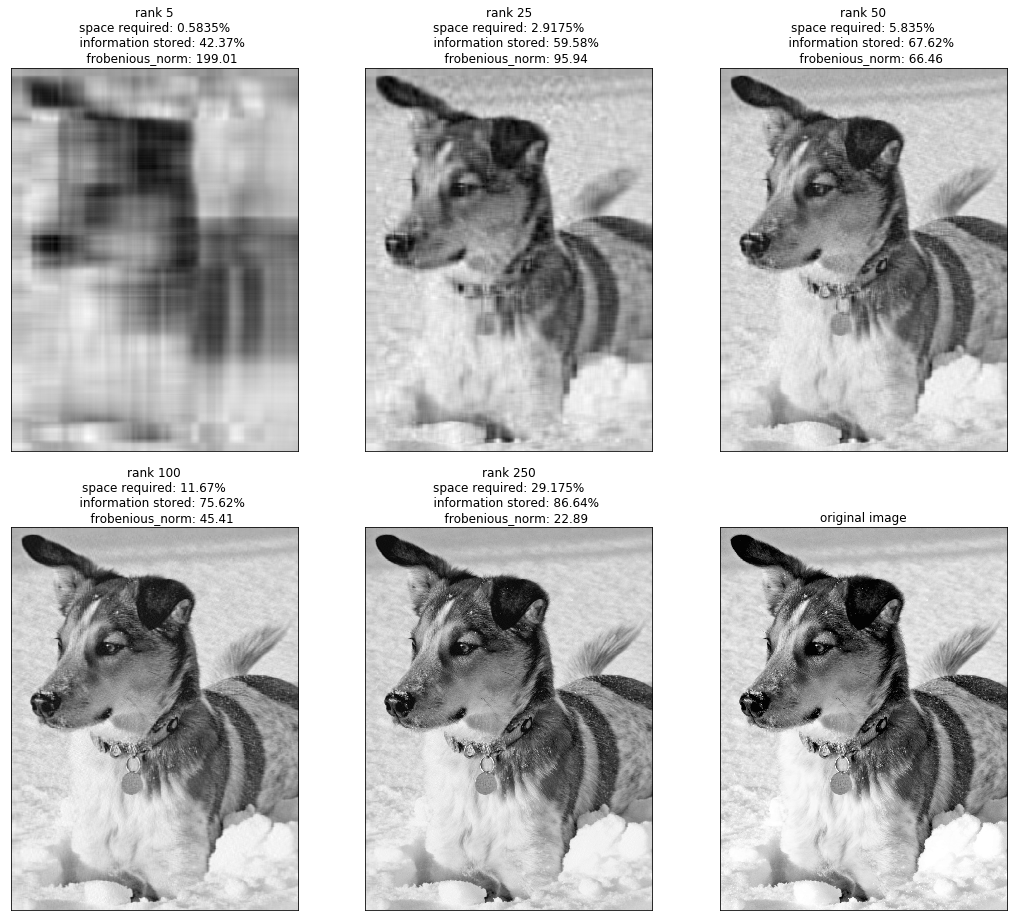

In [8]:
%%time

RANKS = [5, 25, 50, 100, 250]

fig = plt.figure(0, (18, 12))
fig.subplots_adjust(top=1.1)

for idx, r in enumerate(RANKS):
    X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]

    ax = plt.subplot(2,3, idx+1)
    ax.imshow(X_r, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(f'''rank {r}\nspace required: {perc_storage(r, n_rows, n_cols)}%
    information stored: {round(perc_energy(S, r), 2)}%
    frobenious_norm: {round(frobenious_norm(img_gray, X_r), 2)}''')
    
ax = plt.subplot(2, 3, idx+2)
ax.imshow(img_gray, cmap='gray')
ax.set_title('original image')
ax.set_xticks([])
ax.set_yticks([])

CPU times: user 37.6 s, sys: 576 ms, total: 38.2 s
Wall time: 19.2 s


Text(0.5, 1.0, 'rank   v/s   percentage_storage_required')

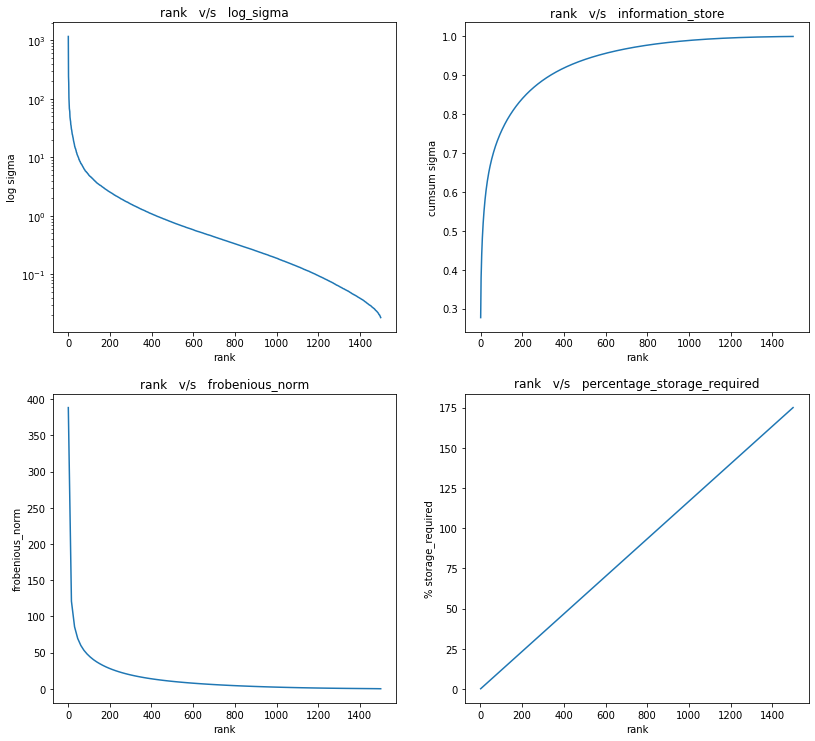

In [9]:
%%time

fig = plt.figure(0, (12, 6))
fig.subplots_adjust(top=1.7, right=1.)

ax1 = plt.subplot(2, 2, 1)
ax1.semilogy(np.diag(S))
ax1.set_xlabel('rank')
ax1.set_ylabel('log sigma')
ax1.set_title('rank   v/s   log_sigma')

ax2 = plt.subplot(2, 2, 2)
ax2.plot(np.cumsum(np.diag(S) / np.sum(np.diag(S))))
ax2.set_xlabel('rank')
ax2.set_ylabel('cumsum sigma')
ax2.set_title('rank   v/s   information_store')

frob_norm = []
perc_strg = []
x_ticks = []
rank = np.linalg.matrix_rank(img_gray)
for r in np.linspace(1, rank, 100):
    r = int(r)
    x_ticks.append(r)

    X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]
    
    frob_norm.append(frobenious_norm(img_gray, X_r))
    perc_strg.append(perc_storage(r, n_rows, n_cols))
    

ax3 = plt.subplot(2, 2, 3)
ax3.plot(x_ticks, frob_norm)
ax3.set_xlabel('rank')
ax3.set_ylabel('frobenious_norm')
ax3.set_title('rank   v/s   frobenious_norm')

ax4 = plt.subplot(2, 2, 4)
ax4.plot(x_ticks, perc_strg)
ax4.set_xlabel('rank')
ax4.set_ylabel('% storage_required')
ax4.set_title('rank   v/s   percentage_storage_required')

In [10]:
print(f'max frob_norm: {frob_norm[0]}')
print(f'min frob_norm: {frob_norm[len(frob_norm)-1]}')

max frob_norm: 388.3993171956575
min frob_norm: 2.8184356293516338e-12


## Colored Compression

In [11]:
%%time

max_energy=85
max_storage=30
max_norm=30

opt_rank_by_energy = get_optimal_rank(img, by='energy', max_energy=max_energy)
opt_rank_by_storage = get_optimal_rank(img, by='storage', max_storage=max_storage)
opt_rank_by_norm = get_optimal_rank(img, by='norm', max_norm=max_norm)

print(f'optimum rank for {max_energy}% energy is {opt_rank_by_energy}')
print(f'optimum rank for {max_storage}% storage is {opt_rank_by_storage}')
print(f'optimum rank for frob_norm={max_norm} is {opt_rank_by_norm}')
print('\n\n')

optimum rank for 85% energy is 220
optimum rank for 30% storage is 224
optimum rank for frob_norm=30 is 193



CPU times: user 1min 38s, sys: 4.96 s, total: 1min 43s
Wall time: 52 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 23.9 s, sys: 1.44 s, total: 25.4 s
Wall time: 15.3 s


[]

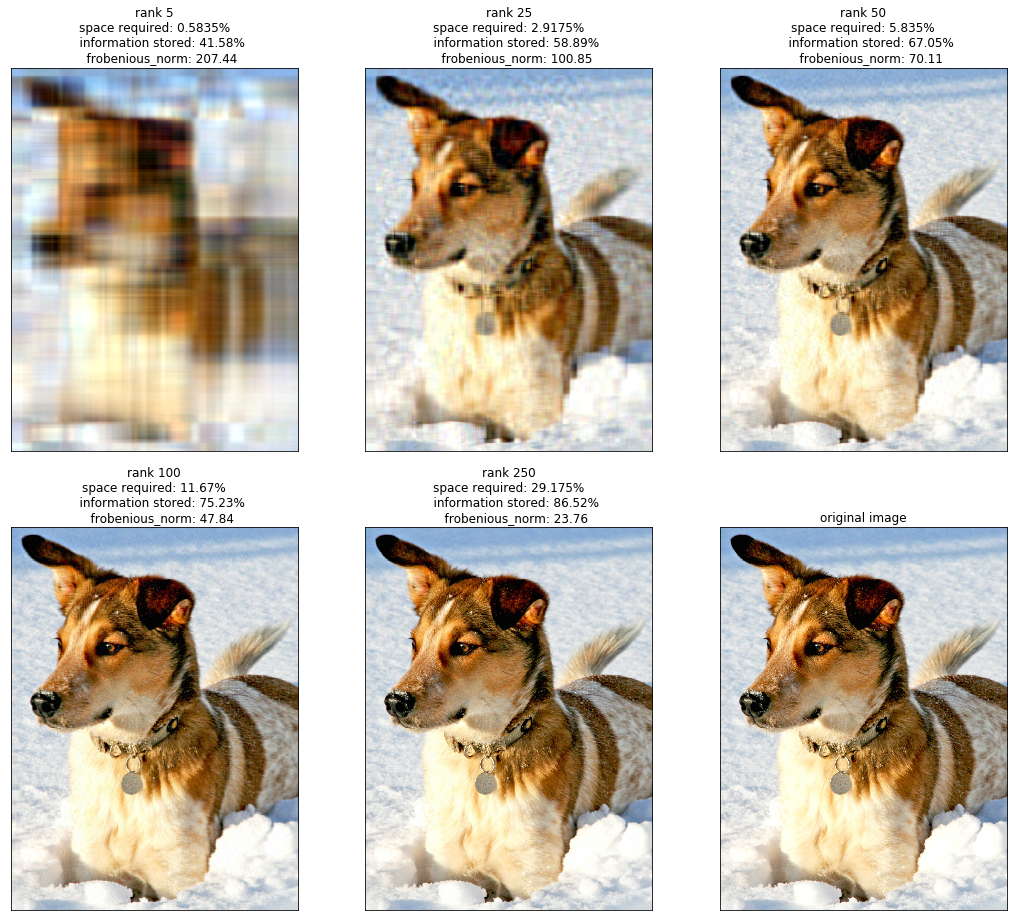

In [12]:
%%time

RANKS = [5, 25, 50, 100, 250]

red_channel, green_channel, blue_channel =  img[:, :, 0], img[:, :, 1], img[:, :, 2]

U_B, S_B, VT_B = svd(blue_channel)
U_G, S_G, VT_G = svd(green_channel)
U_R, S_R, VT_R = svd(red_channel)
    
fig = plt.figure(0, (18, 12))
fig.subplots_adjust(top=1.1)

for idx, r in enumerate(RANKS):
    XR_r = U_R[:, :r] @ S_R[:r, :r] @ VT_R[:r, :]
    XG_r = U_G[:, :r] @ S_G[:r, :r] @ VT_G[:r, :]
    XB_r = U_B[:, :r] @ S_B[:r, :r] @ VT_B[:r, :]

    X_r = np.dstack((XR_r, XG_r, XB_r))
    
    info_stored = np.mean(
        [
            perc_energy(S_R, r),
            perc_energy(S_G, r),
            perc_energy(S_B, r),
        ]
    )

    frob_norm = np.mean(
            [
                frobenious_norm(red_channel, XR_r),
                frobenious_norm(green_channel, XG_r),
                frobenious_norm(blue_channel, XB_r),
            ]
        )

    ax = plt.subplot(2,3, idx+1)
    ax.imshow(X_r)
    ax.set_xticks([])
    ax.set_yticks([])
        
    ax.set_title(f'''rank {r}\nspace required: {perc_storage(r, n_rows, n_cols)}%
    information stored: {round(info_stored, 2)}%
    frobenious_norm: {round(frob_norm, 2)}''')
    
ax = plt.subplot(2, 3, idx+2)
ax.imshow(img)
ax.set_title('original image')
ax.set_xticks([])
ax.set_yticks([])

CPU times: user 54.8 s, sys: 828 ms, total: 55.6 s
Wall time: 27.9 s


Text(0.5, 1.0, 'rank   v/s   percentage_storage_required')

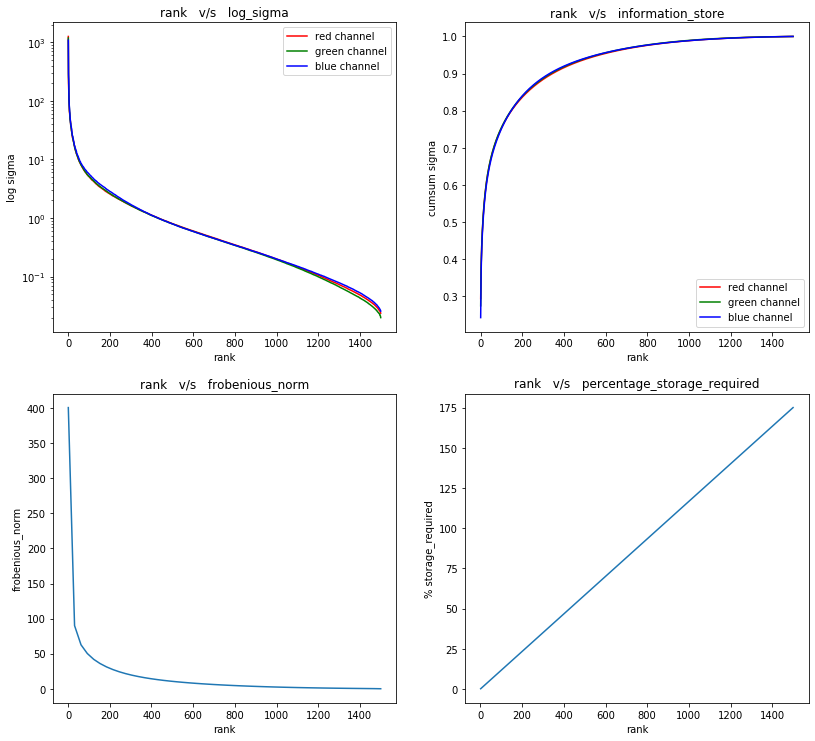

In [13]:
%%time

fig = plt.figure(0, (12, 6))
fig.subplots_adjust(top=1.7, right=1.)

ax1 = plt.subplot(2, 2, 1)
ax1.semilogy(np.diag(S_R), 'r')
ax1.semilogy(np.diag(S_G), 'g')
ax1.semilogy(np.diag(S_B), 'b')
ax1.legend(['red channel', 'green channel', 'blue channel'])
ax1.set_xlabel('rank')
ax1.set_ylabel('log sigma')
ax1.set_title('rank   v/s   log_sigma')

ax2 = plt.subplot(2, 2, 2)
ax2.plot(np.cumsum(np.diag(S_R) / np.sum(np.diag(S_R))), 'r')
ax2.plot(np.cumsum(np.diag(S_G) / np.sum(np.diag(S_G))), 'g')
ax2.plot(np.cumsum(np.diag(S_B) / np.sum(np.diag(S_B))), 'b')
ax2.legend(['red channel', 'green channel', 'blue channel'])
ax2.set_xlabel('rank')
ax2.set_ylabel('cumsum sigma')
ax2.set_title('rank   v/s   information_store')

frob_norm = []
perc_strg = []
x_ticks = []
rank = np.linalg.matrix_rank(img_gray)
for r in np.linspace(1, rank, 50):
    r = int(r)
    x_ticks.append(r)

    XR_r = U_R[:, :r] @ S_R[:r, :r] @ VT_R[:r, :]
    XG_r = U_G[:, :r] @ S_G[:r, :r] @ VT_G[:r, :]
    XB_r = U_B[:, :r] @ S_B[:r, :r] @ VT_B[:r, :]

    frob_norm.append(
        np.mean(
            [
                frobenious_norm(red_channel, XR_r),
                frobenious_norm(green_channel, XG_r),
                frobenious_norm(blue_channel, XB_r),
            ]
        )
    )

    perc_strg.append(perc_storage(r, n_rows, n_cols))


ax3 = plt.subplot(2, 2, 3)
ax3.plot(x_ticks, frob_norm)
ax3.set_xlabel('rank')
ax3.set_ylabel('frobenious_norm')
ax3.set_title('rank   v/s   frobenious_norm')

ax4 = plt.subplot(2, 2, 4)
ax4.plot(x_ticks, perc_strg)
ax4.set_xlabel('rank')
ax4.set_ylabel('% storage_required')
ax4.set_title('rank   v/s   percentage_storage_required')

In [14]:
print(f'max frob_norm: {frob_norm[0]}')
print(f'min frob_norm: {frob_norm[len(frob_norm)-1]}')

max frob_norm: 400.8964978550444
min frob_norm: 7.214129953826785e-12


In [15]:
tok = time.time()
print(f'total time taken by notebook: {round(tok-tik, 2)} sec')

total time taken by notebook: 149.54 sec
